# How to deal with unknown cases

In this tutorial, we are going to explore the effect of unknown cases. The official data on Covid-19 infections only reports known cases whereas in simulations with sid, we know the actual number of infections.

sid allows to model testing in a three-step process which is explained in [another tutorial](how_to_test.ipynb). The testing models allow to implement testing in a bottum-up approach where indviduals can request tests, tests are distributed and processed. This approach might be difficult to implement in real-world settings because the parameters of the testing models are hard to infer. For example, governments have opted for different and specific rules to regulate the access to tests which, in turn, requires detailed individual-level data.

Thus, this notebook details a top-down approach to implement testing. In this setting, the number of all cases is infered from estimates of the infection-fatality-ratio which gives us estimates for the ratio of known active infections to all all active infections.

The factor can be pass to the simulate function as a float or a series with a timestamp index to have factors for each day. During the simulation, the share of known active infections is calculated with the factor. Then, we sample as many individuals with unknown active infections until the calculated number of known active infections matches the internal number of known infections. Sampled individuals will receive a test result in the following days specified by some stochastic process. The following process has the full probability mass at two days.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sid
from sid.config import INDEX_NAMES

## Creating the initial states

Let's create an artificial population of 10 000 people. 
Every individual will be characterized by its region and age group.

The age group will affect the progression of the disease.
Both region and age group will have an influence on who our individuals are going to meet.

In [2]:
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)

initial_states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")
initial_states.head(5)

,age_group,region
0,20-29,North
1,10-19,South
2,20-29,South
3,20-29,South
4,80-100,South


## Specifying the Contact Models

Next, let's define how many contacts people have every day. 
We assume people have two types of contacts, close and distant contacts. They also have fewer close than distant contacts.

In [3]:
def meet_distant(states, params, seed):
    possible_nr_contacts = np.arange(10)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, seed):
    possible_nr_contacts = np.arange(5)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
}

## Specifying the model parameters

sid allows to estimate one infection probability per contact type. 
In this example, close contacts are more infectious than distant contacts with 5% versus 3%. 

In [4]:
epidemiological_parameters = pd.read_csv("infection_probs.csv", index_col=INDEX_NAMES)
epidemiological_parameters

value  note  source
category       subcategory name                          
infection_prob close       close       0.05   NaN     NaN
               distant     distant     0.03   NaN     NaN
               household   household   0.20   NaN     NaN

Similarly, we specify for each contact model how assortatively
people meet across their respective `assort_by` keys. 

We assume that 90% of contacts are with people from the same region and 50% with contacts of the same age group as oneself for both "meet_close" and "meet_distant". 
The rest of the probability mass is split evenly between the other regions and age groups.

In [5]:
assort_probs = pd.read_csv("assort_by_params.csv", index_col=INDEX_NAMES)
assort_probs

value  note  source
category             subcategory name                          
assortative_matching close       age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN
                     distant     age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN

Lastly, we load some parameters that specify how Covid-19 progresses. This includes asymptomatic cases and covers that sever cases are more common among the elderly.

`cd_` stands for countdown. When a countdown is -1 the event never happens. So for example, 25% of infected people will never develop symptoms and the rest will develop symptoms 3 days after they start being infectious. 

In [6]:
disease_params = sid.get_epidemiological_parameters()
disease_params.head(6).round(2)

value
category           subcategory        name                     
health_system      icu_limit_relative icu_limit_relative  50.00
cd_immune_false    all                1000                 1.00
cd_infectious_true all                1                    0.39
                                      2                    0.35
                                      3                    0.22
                                      5                    0.04

In [7]:
params = pd.concat([disease_params, epidemiological_parameters, assort_probs])

## Contact Policies

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

You could also implement policies inside the contact models. This allows you more flexibility. For example, we could implement that sick individuals stay home, that vulnerable people react with stricter social distancing or implement the [locally adaptive lockdown policy in Germany](https://www.dw.com/en/merkel-cautiously-optimistic-as-she-announces-lockdown-rollback/a-53346427).

In [8]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1


contact_policies = {
    "policy_close_contacts": {
        "start": "2020-03-12",
        "policy": 0.5,
        "is_active": contact_policy_is_active,
        "affected_contact_model": "close",
    },
    "policy_distant_contacts": {
        "start": "2020-03-12",
        "policy": 0.5,
        "is_active": contact_policy_is_active,
        "affected_contact_model": "distant",
    },
}

## Initial Conditions

Finally, there must be some initial infections in our population. This is specified via the initial conditions which are thouroughly explained in the [how-to guide](../how_to_guides/how_to_use_initial_conditions.ipynb). For now, we assume that there are 100 infected individuals and 50 with pre-existing immunity.

In [9]:
initial_conditions = {"initial_infections": 100, "initial_immunity": 50}

## Share of known cases

In [10]:
share_known_cases = pd.Series(index=pd.date_range(start="2020-02-27", periods=365), data=1 / 3)

## Processing time for tests

The processing time for tests can be specified with ``"cd_received_test_result_true`` countdown just as any other countdown.

In [11]:
params.loc["cd_received_test_result_true"]

,,value,note,source
subcategory,name,,,
all,2,1.0,NaN,NaN


## Run the simulation

We are going to simulate this population for 200 periods.

In [12]:
simulate = sid.get_simulate_func(
    initial_states=initial_states,
    contact_models=contact_models,
    params=params,
    contact_policies=contact_policies,
    initial_conditions=initial_conditions,
    duration={"start": "2020-02-27", "periods": 365},
    share_known_cases=share_known_cases,
    seed=0,
)
result = simulate(params=params)

Start the simulation...
2021-02-25: 100%|████████████████████████████████████████████████████████████████████| 365/365 [00:46<00:00,  7.90it/s]


The return of `simulate` is a dictionary with containing the time series data and the last states as a [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html). This allows to load the data lazily.

The ``last_states`` can be used to resume the simulation. We will inspect the ``time_series`` data. If data data fits your working memory, do the following to convert it to a pandas DataFrame.

In [13]:
df = result["time_series"].compute()

Let us take a look at various statistics of the sample.

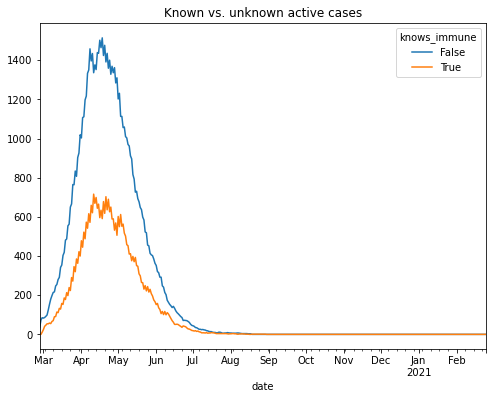

In [14]:
df["active_infection"] = df.eval("infectious | symptomatic")
data = df.groupby([pd.Grouper(key="date", freq="D"), "knows_immune"])["active_infection"].sum().unstack().fillna(0)
data.plot(figsize=(8, 6), title="Known vs. unknown active cases");

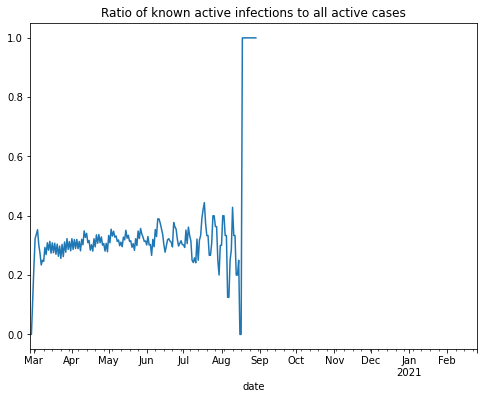

In [15]:
(data[True] / (data[True] + data[False])).plot(figsize=(8, 6), title="Ratio of known active infections to all active cases");

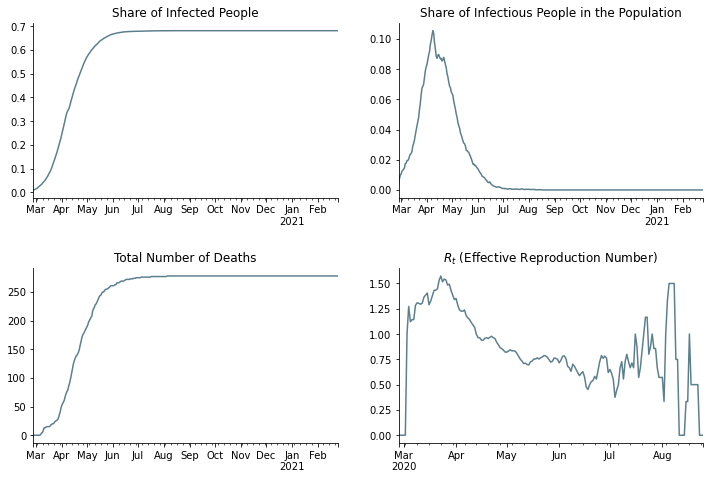

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

df.resample("D", on="date")["ever_infected"].mean().plot(ax=axs[0], color="#5c7f8e")
df.resample("D", on="date")["infectious"].mean().plot(ax=axs[1], color="#5c7f8e")
df.resample("D", on="date")["dead"].sum().plot(ax=axs[2], color="#5c7f8e")
infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].resample("D", on="date")[
    "n_has_infected"
].mean().plot(ax=axs[3], color="#5c7f8e")

for ax in axs:
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_t$ (Effective Reproduction Number)")

plt.show()